In [1]:
import requests
import pprint
import json
import pandas as pd
import numpy as np
import tensorflow
import pickle
import matplotlib.pyplot as plt
from math import ceil
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix, hstack

Get the hero dictionary:

In [2]:
h = requests.get("https://api.opendota.com/api/heroes")
hero_df = pd.DataFrame(json.loads(h.text))

In [3]:
hero_df.head()

,attack_type,id,legs,localized_name,name,primary_attr,roles
0,Melee,1,2,Anti-Mage,npc_dota_hero_antimage,agi,"[Carry, Escape, Nuker]"
1,Melee,2,2,Axe,npc_dota_hero_axe,str,"[Initiator, Durable, Disabler, Jungler]"
2,Ranged,3,4,Bane,npc_dota_hero_bane,int,"[Support, Disabler, Nuker, Durable]"
3,Melee,4,2,Bloodseeker,npc_dota_hero_bloodseeker,agi,"[Carry, Disabler, Jungler, Nuker, Initiator]"
4,Ranged,5,2,Crystal Maiden,npc_dota_hero_crystal_maiden,int,"[Support, Disabler, Nuker, Jungler]"


# Useful functions #

In [26]:
def import_the_data():
    infile = open('X_big_cat_2','rb')
    X = pickle.load(infile)
    infile.close()
    infile = open('y_big_cat','rb')
    y = pickle.load(infile)
    infile.close()
    return X,y

def string_to_array(radiant,dire):
    X = np.zeros(232)
    for item in radiant:
        idx = hero_df[hero_df['localized_name']==item].index[0]
        X[idx] += 1
    for item in dire:
        idx = hero_df[hero_df['localized_name']==item].index[0] + 116
        X[idx] +=1
    return X

def combine_two_files(X1,X2,y1,y2):
    X = np.vstack((X1,X2))
    y = np.vstack((y1,y2))
    return X,y

def validation_plots():
    plt.figure(figsize = (14,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

In [5]:
X,y = import_the_data()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5)
print(' X_train shape:', X_train.shape, '\n', 'X_test shape:', X_test.shape, '\n', 'X_val shape:', X_val.shape)

 X_train shape: (106720, 260) 
 X_test shape: (13341, 260) 
 X_val shape: (13340, 260)


We have a lot of data, so a neural network makes sense; however, a relatively low number of features (260) suggests that gradient boosting might do well. Let's try both, after fitting logistic regression as a baseline.

# Logistic regression #

In [6]:
from sklearn.linear_model import LogisticRegressionCV

Cs = np.logspace(-3,4,10)
lr = LogisticRegressionCV(Cs=Cs)
lr.fit(X_train,y_train)
print('Testing score:', lr.score(X_test,y_test))
print('Training score:', lr.score(X_train,y_train))

C:\Users\Gintas\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gintas\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Gintas\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Testing score: 0.5677235589536017
Training score: 0.5645520989505247


# Neural network #

Now, what kind of architecture should be used here?

The simple, sparse input form means the network is very prone to overfitting (though the input is mostly zeroes, theres over 1e13 combinations of 1s to distribute there, each of these 1e13 corresponding to a wildly different set of hero choices and hence a different game) given the network a lot of hidden nodes. There's two ways to go around this - either limit the number of neurons, or introduce some extreme regularisation (dropout around 0.5). Turns out, a larger network with regularisation outperforms a small one by 1-2%.

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
model = Sequential([
    Dense(256, activation = 'tanh', input_dim = X.shape[1]), 
    Dropout(0.5),
    BatchNormalization(),
    Dense(64, activation = 'tanh'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation = 'sigmoid')
])
callback = EarlyStopping(monitor = 'val_loss', patience = 4)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()
history = model.fit(X_train,y_train, 
                              validation_data = (X_val,y_val),
                              batch_size = 10,
                              epochs=20,
                              shuffle = True,
                              callbacks = [callback])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               66816     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total para

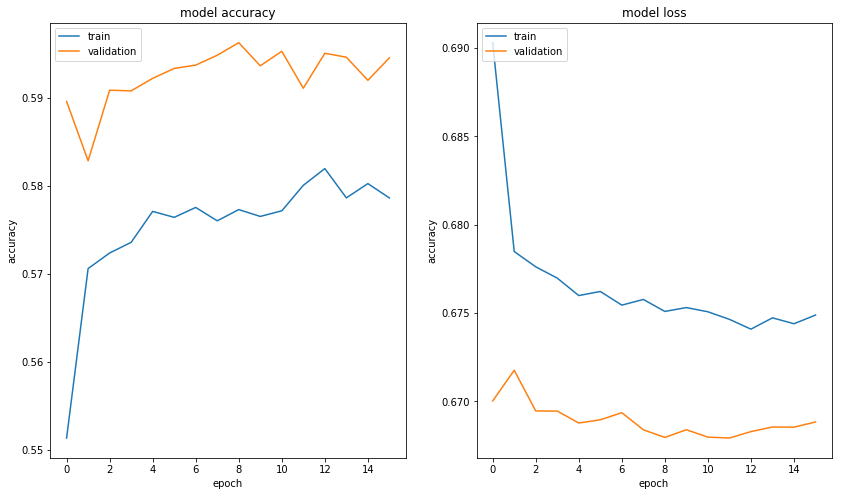

In [31]:
validation_plots()

In [32]:
print('Accuracy on the test set:', model.evaluate(X_test,y_test)[1])

13341/13341 [==============================] - 0s 26us/step
Accuracy on the test set: 0.5938085600645518


## Gradient Boosting Machine (not tuned)##

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier()
gbm.fit(X_train,y_train)
print('Testing score:', gbm.score(X_test,y_test))
print('Training score:', gbm.score(X_train,y_train))

C:\Users\Gintas\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Testing score: 0.5804662319166479
Training score: 0.581718515742129


# Next steps

Ways to improve the accuracy:

-  Features: emphasise popular / high winrate heroes by building features to show what the hero is paired with
-  Tune GBM hyperparameters to build an equally competitive model, then do ensembling
-  Mess around with the NN architecture